<a href="https://colab.research.google.com/github/mijed/MNIST_NN/blob/main/MNIST_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!python --version

Python 3.7.13


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from torchsummary import summary
%matplotlib inline


#Defining datasets (train,test)

transform = transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])

mnist_data = datasets.MNIST('', train=True, download=True, transform=transform)

train_data, validation_data = torch.utils.data.random_split(mnist_data, [50000, 10000])

test_data =  datasets.MNIST("",train=False,download=True,transform = transform)


#Preparing the data - batching and shuffling
BATCH_SIZE = 128

#Data Loaders
train_set = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers = 2,pin_memory = True)
validation_set = torch.utils.data.DataLoader(validation_data,batch_size=BATCH_SIZE,shuffle = True,num_workers = 2,pin_memory = True)
test_set = torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False,num_workers = 2,pin_memory = True)

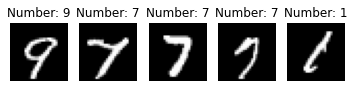

In [19]:
from IPython.core.pylabtools import figsize
#Displaying some examples from dataset
batch = next(iter(train_set))
samples = batch[0][:5]
y_labels = batch[1]

for i, sample in enumerate(samples):
  plt.subplot(1,5,i+1)
  plt.title(f"Number: {y_labels[i]}")
  plt.imshow(sample.numpy().reshape((28,28)),cmap = 'gray')
  plt.axis('off')

In [22]:
#Model definitions

class DeepNN(nn.Module):
    def __init__(self):
        #Inheritance
        super().__init__()

        #Define layers of the network (fully connected layers)
        #Parse flatten images  28x28=784 output
        #Output 10 classes - (digits 0-9)
        #Dropout to prevent overfitting
        self.fc1 = nn.Linear(784,256)
        nn.Dropout(0.45)
        self.fc2 = nn.Linear(256,64)
        nn.Dropout(0.45)
        self.fc3 = nn.Linear(64,64)
        nn.Dropout(0.45)
        self.fc4 = nn.Linear(64,10)

    def forward(self,x):
        #Activation function relu
        #Flattening
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        
        return F.log_softmax(x, dim = 1)


deep = DeepNN()

summary(deep,(1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                   [-1, 64]          16,448
            Linear-3                   [-1, 64]           4,160
            Linear-4                   [-1, 10]             650
Total params: 222,218
Trainable params: 222,218
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.85
Estimated Total Size (MB): 0.85
----------------------------------------------------------------


In [23]:
#Functions for training, validation(testing) and plotting
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean') 
            # get the index of class with the max log-probability 
            prediction = output.argmax(dim=1)  
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel('Average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()


#def plot_confusion_matrix()


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302958
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.229139
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.665776
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.771712

Train set: Average loss: 1.5529
Validation set: Average loss: 0.5604, Accuracy: 8374/10000 (84%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.460054
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.544344
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.374272
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.416861

Train set: Average loss: 0.4159
Validation set: Average loss: 0.3359, Accuracy: 8989/10000 (90%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.283109
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.364989
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.260322
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.219105

Train set: Average loss: 0.3069
Validation set: Average loss: 0.2750, Accuracy: 9204/10000 (92%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.294189
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.350473
Train Epoch: 4 [25600/5

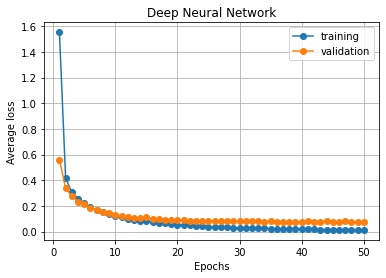

In [24]:
#Experiment
#Deep Neural Network



#If possible work on GPU(CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepNN().to(device)

#Hyperparameters
EPOCHS = 50
LR = 0.01
MOMENTUM = .5
WEIGHT_DECAY = 1e-3

#Seed for SDG
SEED = 123
optimizer = optim.SGD(model.parameters(), 
                      lr=LR, 
                      momentum=MOMENTUM,
                      weight_decay=WEIGHT_DECAY)





train_loss = []
validation_loss = []

for epoch_number in range(1, EPOCHS+ 1):
    train_loss.append(train(model, device, train_set, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_set, 'Validation set'))

test(model, device, test_set, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep Neural Network')






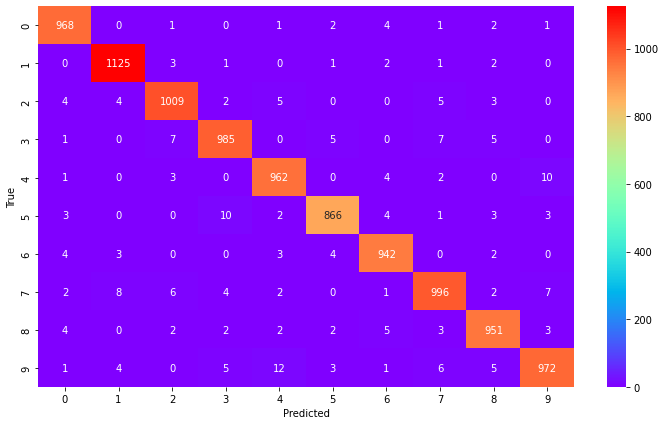

In [25]:
#Confusion Matrix
# Build confusion matrix

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_set:
        output = model(inputs) # Feed Network
        output = (torch.max(output,1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1','2','3','4','5','6','7','8','9')

plt.figure(figsize = (12,7))
# Build confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index = [i for i in classes],
                     columns = [i for i in classes])

df_cm.index.name = 'True'
df_cm.columns.name = 'Predicted'
#fmt = 'd' for displaying numbers in normal notation 
sn.heatmap(df_cm, annot=True,fmt = 'd', cmap = 'rainbow')
plt.show()

In [2]:
#Experiment CNN
# TO DO
#class ConvNet():

  #def __init__(self):
    #super().__init__()



